In [5]:
import json

import pandas as pd
import matplotlib.pyplot as plt

from python_anesthesia_simulator import metrics
from close_loop_anesth.experiments import compute_cost

/home/aubouinb/ownCloud/Code/TIVA_Drug_Control/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

# study to load
study_name_list = ['PID_new_dist', 'MEKF_R_maint', 'MHE_R_maint']

results = []
for study_name in study_name_list:
    # load the study
    with open(f'data/logs/{study_name}.json', 'r') as f:
        dict = json.load(f)

    # load the results
    filename = f'data/signals/{dict["filename"]}'
    results.append(pd.read_csv(filename))

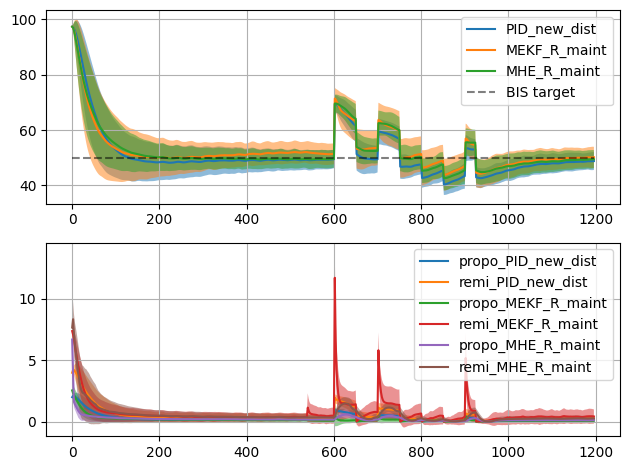

In [7]:
# plot the results
plt.subplot(2, 1, 1)
for i, result in enumerate(results):
    mean_bis = result.groupby('Time')['BIS'].mean()
 
    std_bis = result.groupby('Time')['BIS'].std()

    plt.plot(mean_bis.index, mean_bis, label=study_name_list[i])
    plt.fill_between(mean_bis.index, mean_bis - std_bis, mean_bis + std_bis, alpha=0.5)

plt.hlines(50, 0, max(mean_bis.index), 'black', '--', label='BIS target', alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
for i, result in enumerate(results):
    mean_propo = result.groupby('Time')['u_propo'].mean()
    std_propo = result.groupby('Time')['u_propo'].std()
    mean_remi = result.groupby('Time')['u_remi'].mean()
    std_remi = result.groupby('Time')['u_remi'].std()

    plt.plot(mean_propo.index, mean_propo, label=f'propo_{study_name_list[i]}')
    plt.fill_between(mean_propo.index, mean_propo - std_propo, mean_propo + std_propo, alpha=0.5)
    plt.plot(mean_remi.index, mean_remi, label=f'remi_{study_name_list[i]}')
    plt.fill_between(mean_remi.index, mean_remi - std_remi, mean_remi + std_remi, alpha=0.5)


plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f"outputs/{''.join(study_name_list)}.pdf")

plt.show()

In [8]:
# Compute the metrics
df_metrics = None

MAINTENANCE_TIME = 599

for i, result in enumerate(results):
    for caseid, df_case in result.groupby('caseid'):
        df_line = metrics.compute_control_metrics(df_case.Time.values,
                                                  df_case.BIS.values,
                                                  phase='total',
                                                  start_step=600,
                                                  end_step=900)
        df_line['study'] = study_name_list[i]
        df_line['IAE_i'] = metrics.intergal_absolut_error(df_case[df_case.Time <= MAINTENANCE_TIME].Time.values,
                                                          df_case[df_case.Time <= MAINTENANCE_TIME].BIS.values)

        df_line['IAE_m'] = metrics.intergal_absolut_error(df_case[df_case.Time > MAINTENANCE_TIME].Time.values,
                                                          df_case[df_case.Time > MAINTENANCE_TIME].BIS.values)

        df_line['full_cost_IAE'] = compute_cost(df_case, 'IAE_biased_normal')

        if df_metrics is None:
            df_metrics = df_line
        else:
            df_metrics = pd.concat((df_metrics, df_line), axis=0)

# Compute mean_std, min, and max for each column grouped by 'study'
df_stats = df_metrics.groupby('study').agg(['mean', 'std', 'min', 'max'])

for metric in df_metrics.columns:
    if metric == 'study':
        continue
    if 'IAE' in metric:
        df_stats[metric, 'mean'] = df_stats[metric, 'mean'].astype(int).astype(
            str) + ' ± ' + df_stats[metric, 'std'].astype(int).astype(str)
        df_stats[metric, 'min'] = df_stats[metric, 'min'].astype(int).round(round_number).astype(str)
        df_stats[metric, 'max'] = df_stats[metric, 'max'].astype(int).round(round_number).astype(str)
    else:
        round_number = 2
        df_stats[metric, 'mean'] = df_stats[metric, 'mean'].astype(float).round(round_number).astype(
            str) + ' ± ' + df_stats[metric, 'std'].astype(float).round(round_number).astype(str)
        df_stats[metric, 'min'] = df_stats[metric, 'min'].astype(float).round(round_number).astype(str)
        df_stats[metric, 'max'] = df_stats[metric, 'max'].astype(float).round(round_number).astype(str)
    df_stats = df_stats.drop(columns=[(metric, 'std')])

# remove specific columns
df_stats.drop(columns=[('full_cost_IAE', 'min'),
                       ('IAE_i', 'min'),
                       ('IAE_m', 'min'),
                       ('TT', 'min'),
                       ('BIS_NADIR', 'max'),
                       ('ST10', 'min'),
                       ('ST20', 'min'),
                       ('TTp', 'min'),
                       ('BIS_NADIRp', 'max'),
                       ('TTn', 'min'),
                       ('BIS_NADIRn', 'max'),
                       ('US', 'mean'),
                       ('US', 'min'),
                       ('US', 'max')], inplace=True)

print(df_stats.to_markdown())

df_stats_induction = df_stats[['IAE_i', 'TT', 'BIS_NADIR', 'ST10', 'ST20']]
df_stats_maintenance = df_stats[['IAE_m', 'TTp', 'BIS_NADIRp', 'TTn', 'BIS_NADIRn']]

# export induction to latex table
styler = df_stats_induction.style
filename = f'./outputs/inducion_{"".join(study_name_list)}.tex'
styler.to_latex(filename, hrules=True, column_format='l|'+'cc|'*5)

# in the latex file replace every '_' by '\_'
# in the latex file replace every '±' by '$\pm$'

with open(filename, 'r') as file:
    filedata = file.read()
    filedata = filedata.replace('_', '\_')
    filedata = filedata.replace('±', '$\pm$')
with open(filename, 'w') as file:
    file.write(filedata)

# export induction to latex table
styler = df_stats_maintenance.style
filename = f'./outputs/maintenance_{"".join(study_name_list)}.tex'
styler.to_latex(filename, hrules=True, column_format='l|'+'cc|'*5)

# in the latex file replace every '_' by '\_'
# in the latex file replace every '±' by '$\pm$'

with open(filename, 'r') as file:
    filedata = file.read()
    filedata = filedata.replace('_', '\_')
    filedata = filedata.replace('±', '$\pm$')
with open(filename, 'w') as file:
    file.write(filedata)


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.